<a href="https://colab.research.google.com/github/sugarlin1732/DogsVSCats/blob/master/Dog_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Download kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"ytlin1732","key":"264f09c1be8e9ef7feb868fd33e33c9a"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content

 96% 521M/544M [00:07<00:00, 67.4MB/s]
100% 544M/544M [00:07<00:00, 72.7MB/s]
 98% 267M/271M [00:02<00:00, 156MB/s]
100% 271M/271M [00:02<00:00, 126MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 101MB/s]


In [0]:
# unzip
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      

In [0]:
# import packages
import os
import cv2
import random
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.layers import Concatenate,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [0]:
# # load data ans
# data_list = os.listdir(".//train")

data_ans = [i.split(".")[0] for i in data_list]
le = LabelEncoder()
le.fit(list(set(data_ans)))
print(data_ans[:20])
data_ans = np.array(le.transform(data_ans))
print(data_ans[:20])
# train_ans = le.inverse_transform(train_ans)
# print(train_ans[:20])

data_ans = to_categorical(data_ans, len(le.classes_))
print(data_ans[:20])

['dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog']
[1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [0]:
# # load  pic
pic_list = []
imgsize = 150
for i in data_list:
    img = cv2.imread(".//train//" + i, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (imgsize, imgsize))
    pic_list.append(np.array(img))
pic_list = np.array(pic_list)

In [0]:
# shuffle the pic order
temp = list(zip(pic_list, data_ans))
random.shuffle(temp)
pic_list, data_ans = zip(*temp)
pic_list=np.asarray(pic_list)
data_ans=np.asarray(data_ans)

In [0]:
# split training data to 0.7 training / 0.15 validation / 0.15 testing

pic_list = pic_list[:4000]
data_ans = data_ans[:4000]

X_train, X_tmp, Y_train, Y_tmp = train_test_split(pic_list, data_ans, test_size=0.3, random_state=0)
X_test, X_val, Y_test, Y_val = train_test_split(X_tmp, Y_tmp, test_size=0.5, random_state=0)

print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)



(2800, 2)
(600, 2)
(600, 2)


In [0]:
# set EarlyStopping to prevent overfitting
ES = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=50, verbose=1, mode="auto")


In [0]:
# set ReduceLROnPlateau to reduce learning rate
RLR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, verbose=1, mode="auto", min_lr=1e-6)

In [0]:
# use VGG19
VGG19_model = VGG19(include_top=False, weights="imagenet", input_shape=(imgsize, imgsize, 3))
# VGG19_model = VGG19(include_top=False, weights=None, input_shape=(imgsize, imgsize, 3), pooling="max")

for layer in VGG19_model.layers:
    layer.trainable=False

In [0]:
# build model
model = Sequential()
model.add(VGG19_model)
# for layer in VGG19_model.layers:
#     layer.trainable=False
#     model.add(layer)
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                

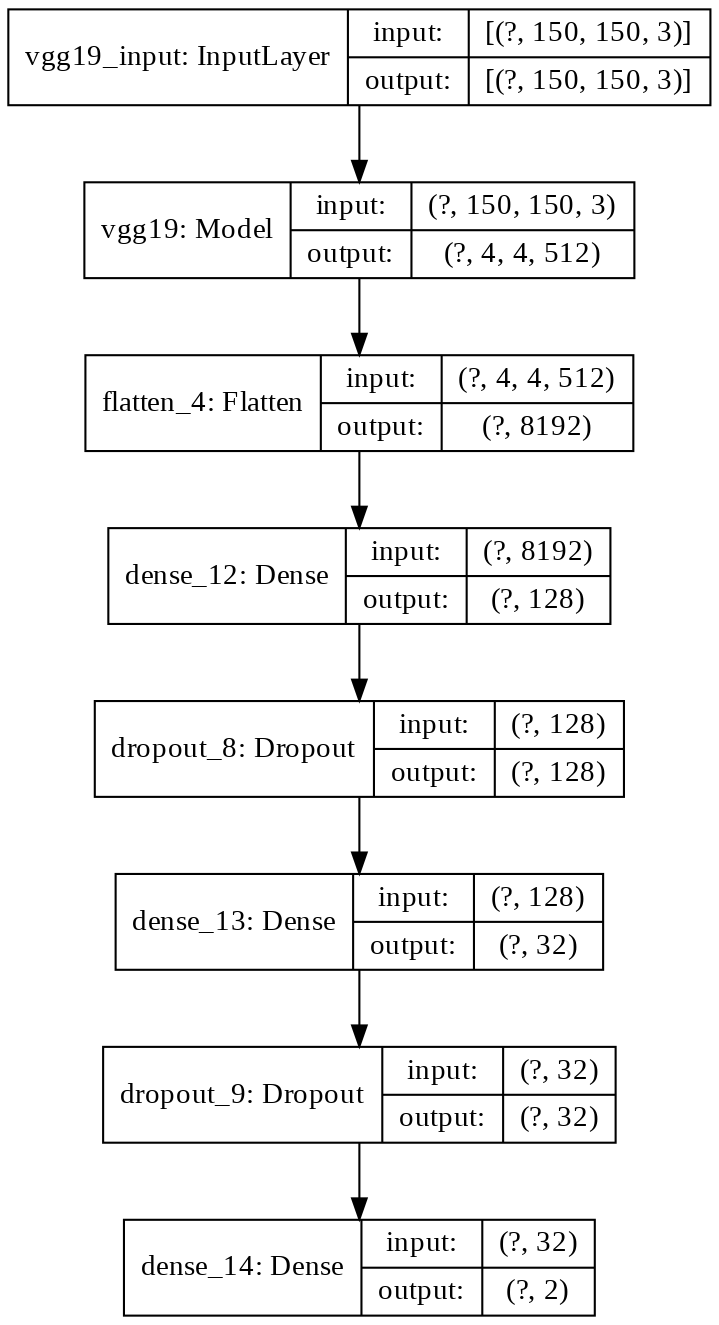

In [0]:
# model visualization
plot_model(model, show_shapes=True, dpi=150)

In [0]:
# model compile and training
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
# model.compile(optimizer="RMSprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=50, epochs=100, callbacks=[ES, RLR], 
                          steps_per_epoch = X_train.shape[0]/50,                          
                          validation_data = (X_val, Y_val),
                          validation_steps = X_val.shape[0]/50
                          )

Epoch 1/100
56/56 [==============================] - 13s 239ms/step - loss: 0.0701 - accuracy: 0.9779 - val_loss: 0.1655 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 13s 240ms/step - loss: 0.0381 - accuracy: 0.9893 - val_loss: 0.1955 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - 13s 240ms/step - loss: 0.0274 - accuracy: 0.9886 - val_loss: 0.1966 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - 13s 240ms/step - loss: 0.0306 - accuracy: 0.9896 - val_loss: 0.2422 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/100
56/56 [==============================] - 13s 238ms/step - loss: 0.0219 - accuracy: 0.9889 - val_loss: 0.2727 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 6/100
56/56 [==============================] - 13s 238ms/step - loss: 0.0184 - accuracy: 0.9932 - val_loss: 0.2787 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 7/100
56/56 [==============================] - 13s 2

In [0]:
# testing set evaluation
test_score = model.evaluate(X_test, Y_test)
print("Testing Loss =", test_score[0])
print("Testing Accuracy =", test_score[1])

19/19 [==============================] - 3s 156ms/step - loss: 0.1273 - accuracy: 0.9817
Testing Loss = 0.12731871008872986
Testing Accuracy = 0.9816666841506958


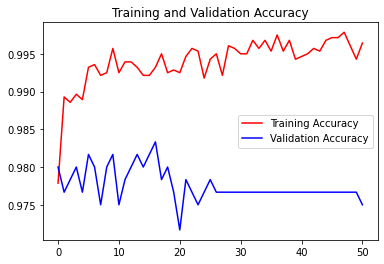

In [0]:
# plot learning curve // training & val acc
acc = history.history["accuracy"]
loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

if ES.stopped_epoch != 0:
    epochs=range(ES.stopped_epoch+1)
else:
    epochs=range(200)

plt.plot(epochs,acc,"r-",label="Training Accuracy")
plt.plot(epochs,val_acc,"b-",label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()



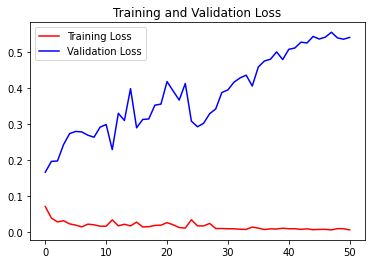

In [0]:
# plot learning curve // training & val loss
plt.plot(epochs,loss,"r-",label="Training Loss")
plt.plot(epochs,val_loss,"b-",label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()